In [1]:
import os
#!TF_CPP_MIN_LOG_LEVEL=0
from time import perf_counter
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from diffusers import schedulers
from PIL import Image
from IPython.utils import io

In [2]:
!nvidia-smi

Mon Oct 31 16:15:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   26C    P8    19W / 300W |      2MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
class cfg:
    token = os.getenv("HF_USER_TOKEN") 
    checkpoint = "runwayml/stable-diffusion-v1-5"
    seed = 12345

In [4]:
#!huggingface-cli login

In [5]:
generator = torch.Generator(device="cuda")
generator.manual_seed(11)

params = {
            "eta": 0.0,
            #"generator": generator.manual_seed(Config.seed),
            "guidance_scale": 7.5,
            "height": 512,
            "width": 512,
            "num_inference_steps": 100,
            "output_type": "pil",   
}

In [6]:
scheduler_params_default = {
                            "beta_start": 0.0001,
                            "beta_end": 0.02,
                            "beta_schedule": "scaled_linear",
                            "num_train_timesteps": 1000
                           }    

schedulers_dict = {
                    "DDIM": schedulers.scheduling_ddim.DDIMScheduler,
                    "PNDM": schedulers.scheduling_pndm.PNDMScheduler,
                    "LMSD": schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
                }

class Inference:
    
    assert torch.cuda.is_available() == True
    generator = torch.Generator(device="cuda")
    
    def __init__(self, scheduler="LMSD", scheduler_params=None):
        
        if not scheduler_params:
            self.scheduler_params = scheduler_params_default
        else:
            sparams = scheduler_params_default.copy()
            for k, v in scheduler_params.items():
                sparams[k] = v
            self.scheduler_params = sparams
            
        self.scheduler = scheduler
        scheduler_obj = schedulers_dict[self.scheduler](**self.scheduler_params)
        
        with io.capture_output() as captured:
            self.pipeline = StableDiffusionPipeline.from_pretrained(cfg.checkpoint, torch_dtype=torch.float16, revision="fp16", use_auth_token=cfg.token)
            #self.pipeline = StableDiffusionPipeline.from_pretrained("./stable-diffusion-v1-5", torch_dtype=torch.float16, revision="fp16")
        self.pipeline.to("cuda")
        self.pipeline.enable_attention_slicing()
        
    def model_input(self, seed):
        generator = torch.Generator(device="cuda")
        generator.manual_seed(seed)
        _inputs = {
                    "eta": 0.0,
                    "generator": generator.manual_seed(seed),
                    "guidance_scale": 7.5,
                    "height": 512,
                    "width": 512,
                    "num_inference_steps": 100,
                    "output_type": "pil",   
                }
        return _inputs
    
    def __call__(self, prompt, seed=cfg.seed, params=None):
        start = perf_counter()
        if not params:
            _params = self.model_input(seed)
        else:
            _params = self.model_input(seed)
            for p, v in params.items():
                _params[p] = v
        with io.capture_output() as captured:
            image = self.pipeline(prompt, **_params).images[0]
        print(f"Run time: {perf_counter() - start: .2f}sec.")
        return image 

In [7]:
image_generator = Inference(scheduler="LMSD")

In [33]:
# inference

Run time:  23.91sec.


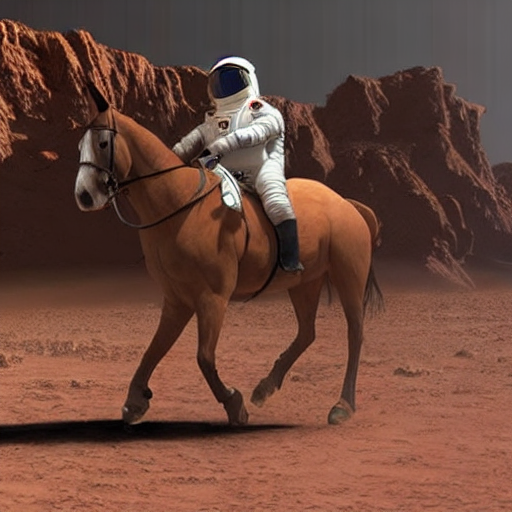

In [34]:
image_generator(prompt="A photo of an astronaut riding a horse on the Mars.", \
              params={"num_inference_steps": 125, "guidance_scale": 7.5}, seed=2**16-1)

Run time:  20.40sec.


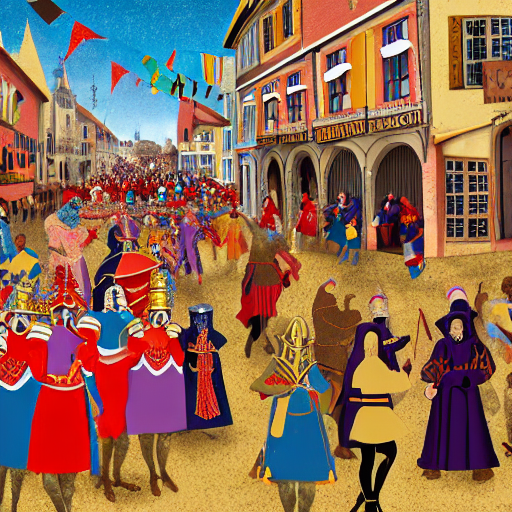

In [17]:
image_generator("An illustration of carnival in a medieval town, 8k, detailed and realistic people in the background.", \
               params={"num_inference_steps": 200, "guidance_scale": 15}, seed=123)

Run time:  15.37sec.


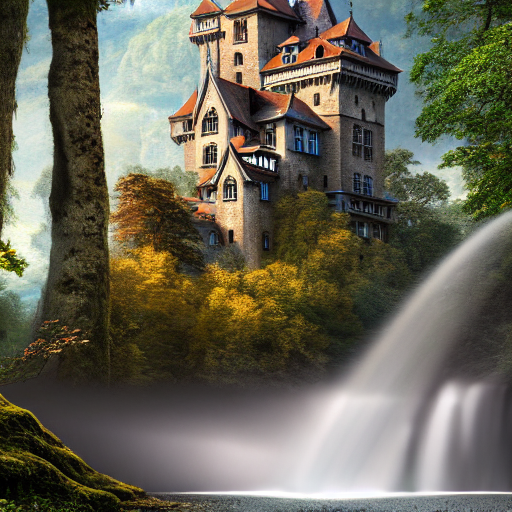

In [18]:
image_generator("A beautiful castle in front of a waterfall in the woods, by Josef Thoma, matte painting, 4k, trending on artstation HQ.", \
               params={"num_inference_steps": 150, "guidance_scale": 15}, seed=123)

Run time:  10.36sec.


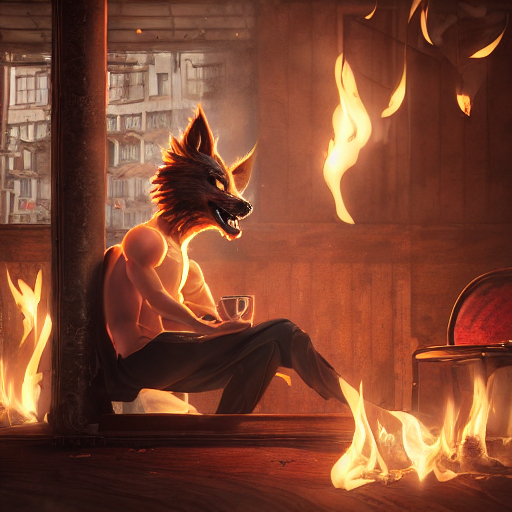

In [19]:
image_generator("An epic and beautiful rococo werewolf drinking coffee in a burning coffee shop - an ultra-detailed, realistic anime, pixiv, uhd 8k cryengine, octane render", \
               params={"num_inference_steps": 100, "guidance_scale": 7.5}, seed=12345)

Run time:  7.85sec.


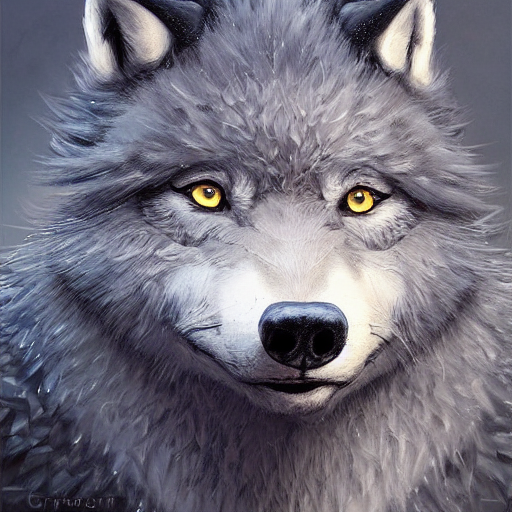

In [64]:
img = image_generator("Anthropomorphic blue-gray furry wolf, digital painting, epic, extremely detailed protrait view, intricate, oil painting, Greg Rutkowski", \
               params={"num_inference_steps": 75, "guidance_scale": 8.5}, seed=12345)
img

In [59]:
img.save("/mnt/data/furry_wolf_1.png")